# Analysis of DSLWP-B first SSDV transmission

This notebook analyzes the first SSDV transmission made by DSLWP-B from the Moon. We study why out of 4 transmitted SSDV frames, the decoding of two of them fails.

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

We load a file containing the relevant GMSK transmission that contains all 4 SSDV frames. The recording was done at the Dwingeloo radiotelescope and can be obtained [here](https://charon.camras.nl/public/dslwp-b/DSLWP-B_PI9CAM_2018-08-03T23:11:10_436.4MHz_40ksps_complex.raw). The 250bps GMSK signal is converted down to baseband and lowpass filtered to 800Hz.

In [2]:
x = np.fromfile('/home/daniel/dslwp_photo_short.c64', dtype='complex64')
fs = 40e3
f = 2410
x = x * np.exp(-1j*2*np.pi*np.arange(x.size)*f/fs)
h = scipy.signal.firwin(1000, 0.01)
x = scipy.signal.lfilter(h, 1, x)

Since the SNR of the recording at Dwingeloo is very good, we can perform noncoherent demodulation of the GMSK signal. The figure below shows some of the GMSK bits.

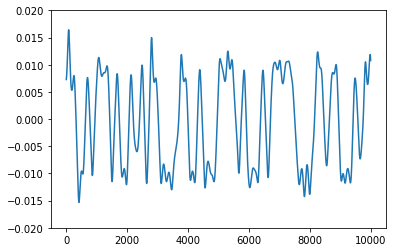

In [3]:
plt.plot(np.diff(np.unwrap(np.angle(x[500000:510000]))))
plt.ylim([-0.02,0.02]);

We extract the soft bits by guessing the correct clock phase and decimating. No pulse shaping matched filtering has been done, and tracking of the clock frequency doesn't seem necessary either. The separation between the bits 1 and 0 is good enough for demodulation without bit errors.

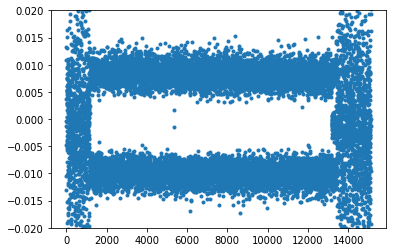

In [4]:
phase = 50
softbits = np.diff(np.unwrap(np.angle(x)))[phase::160]
plt.plot(softbits,'.')
plt.ylim([-0.02,0.02]);

Soft bits are now converted to hard bits.

In [5]:
bits = (softbits > 0)*1

We construct the CCSDS ASM used to mark the beginning of each Turbo coded word. The ASM is precoded as indicated by the CCSDS standard. See [this post](http://destevez.net/2018/06/dslwp-b-gmsk-detector/) for more information.

In [6]:
asm = np.unpackbits(np.array([0x03,0x47,0x76,0xC7,0x27,0x28,0x95,0xB0], dtype='uint8'))
asm_diff = asm[:-1] ^ asm[1:]
asm_diff[1::2] ^= 1

We correlated the received hard bits against the precoded ASM. The length of the ASM is 63 bits, so a correlation of 63 indicates that the ASM is found without bit errors. We see that the ASM is found 4 times without any bit errors. Each of these occurences of the ASM marks the start of a Turbo codeword containing a single SSDV frame.

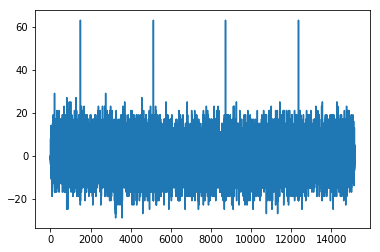

In [7]:
asm_corr = scipy.signal.correlate(2*bits-1, 2*asm_diff.astype('float')-1)
plt.plot(asm_corr)

We now look at the distances between the ASMs. DSLWP-B uses Turbo codewords of 3576 symbols. Since the ASM is 64 bits long and Turbo codewords are transmitted back-to-back, without any gap between them, we expect a distance of 3640 bits. 

Note that before we have stated that the ASM is 63 bits long. This is because the GMSK precoder is differential, so the first bit of the ASM is not defined, as it depends on the preceding data. Thus, we only use the 63 bits of the ASM that are fixed when doing the correlation.

Below we show the distances between the ASMs.

In [8]:
np.diff(np.where(asm_corr > 40)[0])

array([3640, 3597, 3640])

We see that the distance between ASM 0 and ASM 1 is correct. Likewise, the distance between the ASM 2 and ASM 3 is correct. However, the distance between ASM 1 and ASM 2 is only 3597 bits. This means that the second Turbo codeword was somehow cut short and not transmitted completely (43 bits are missing).

In a similar manner, the fourth Turbo codeword was also cut short. Indeed, the transmitter goes off before the Turbo codeword has been transmitted completely. Indeed, the distance between ASM 3 and the end of the file is:

In [9]:
asm_corr.size-np.where(asm_corr > 40)[0][-1]

2808

It seems that for some reason DSLWP-B cut short the second and fourth Turbo codewords, which explains why the corresponding SSDV frames cannot be decoded. The only other reasonable explanation is that some samples where lost in the recording made at Dwingeloo. However, this seems very unlikely, since there is good phase continuity of the signal all along the GMSK transmission, as the figure below shows.